# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
views_max = df.email.value_counts().max()

In [4]:
views_median = df.email.value_counts().median()

In [5]:
print('The user with the most view has viewed {0} articles but average users view {1} in medaian.'.format(views_max, views_median))

The user with the most view has viewed 364 articles but average users view 3.0 in medaian.


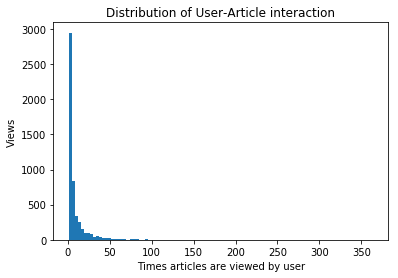

In [6]:
#df.email.value_counts().plot.density()
plt.hist(df.email.value_counts(), bins=100, density=False)
plt.title('Distribution of User-Article interaction')
plt.xlabel('Times articles are viewed by user')
plt.ylabel('Views')
plt.show()

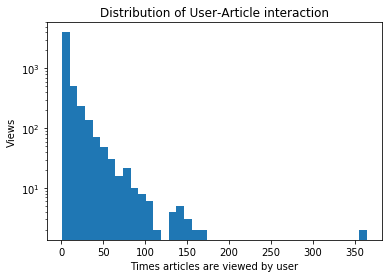

In [7]:
# see more details on the users with many views
plt.hist(df.email.value_counts(), bins=40, log=True, density=False)
plt.title('Distribution of User-Article interaction')
plt.xlabel('Times articles are viewed by user')
plt.ylabel('Views')
plt.show()

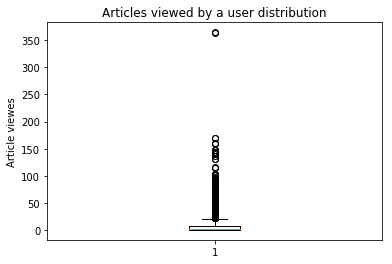

In [8]:
plt.boxplot(df.email.value_counts())
plt.title('Articles viewed by a user distribution')
plt.ylabel('Article viewes')
plt.show()

In [9]:
# Fill in the median and maximum number of user_article interactios below

median_val = views_median # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = views_max # The maximum number of user-article interactions by any 1 user is ______.

# `2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [10]:
# Find and explore duplicate articles
df_duplicates = df_content[df_content.duplicated()==True]
if df_duplicates.shape[0] == 0: 
    print('There are no duplicated rows in the content dataframe df_content. Next check it ther are some articles have the same article_id')
else:
    df_duplicates.head()

There are no duplicated rows in the content dataframe df_content. Next check it ther are some articles have the same article_id


In [11]:
# Remove any rows that have the same article_id - only keep the first
df_id_dublicates = df_content[df_content['article_id'].duplicated()==True]
id_dublicates = df_id_dublicates.shape[0]
if df_id_dublicates.shape[0]==0:
    print('There are no articles with the same article_id.')
else:
    print('There are at least {} articles with the same article_id before cleaning. \nPerforme cleanding...'.format(id_dublicates))

There are at least 5 articles with the same article_id before cleaning. 
Performe cleanding...


In [12]:
df_content = df_content.drop_duplicates(subset=['article_id'])
df_content[df_content['article_id'].duplicated()==True].shape[0]

0

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [13]:
df_interaction = df.drop_duplicates(subset=['article_id'])
articles_w_interaction = df_interaction.shape[0]
print('There are {} articles with at least one reader.'.format(articles_w_interaction))

There are 714 articles with at least one reader.


In [14]:
df_unique_articles = df_content.drop_duplicates(subset=['article_id'])
articles = df_unique_articles.shape[0]
print('There are {} unique articles in the IBM platform.'.format(articles))

There are 1051 unique articles in the IBM platform.


In [15]:
df_users = df.drop_duplicates(subset=['email'])
users = df_users.shape[0]-1
print('There are {} unique users at the IBM platform. This number includes the null values'.format(users))

There are 5148 unique users at the IBM platform. This number includes the null values


In [16]:
df_unique = df.drop_duplicates()
unique_interactions = df_unique.shape[0]
unique_interactions

33682

In [17]:
unique_articles = articles_w_interaction # The number of unique articles that have at least one interaction
total_articles = articles # The number of unique articles on the IBM platform
unique_users = users # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions
print('The number of user article interaction is {}.\nBut if only one interaction per article and user is counted the number is {}'.format(df.shape[0], unique_interactions))

The number of user article interaction is 45993.
But if only one interaction per article and user is counted the number is 33682


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [18]:
def rank_by_view(df):
    df_article_views = df
    df_article_views['views'] = df_article_views.groupby('article_id')['article_id'].transform('count')
    df_article_views = df_article_views.drop_duplicates(subset=['article_id'])
    df_article_views = df_article_views.sort_values(by=['views'], ascending=False)
    
    return df_article_views

df_article_views = rank_by_view(df)
#df_article_views['article_id'][:1]
most_viewed = str(df_article_views['article_id'].iloc[0])
most_times_viewed = df_article_views['views'].max()

#df_article_views[:1]
df_article_views.head()

,article_id,title,email,views
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074,937
66,1330.0,insights from new york car accident reports,20c6b6f18eb5fa53e5559afd74f4ccf01db37594,927
37,1431.0,visualize car data with brunel,3b5c304f93db685df40d297a18e69a4a5b1f14aa,671
42,1427.0,"use xgboost, scikit-learn & ibm watson machine...",430bdfe1dd179eb05abc237d1f498bd5aa2f8fac,643
29,1364.0,predicting churn with the spss random tree alg...,3b241403886ff0b565c4c00bbe5f86647ece0a92,627


In [19]:
print('The article_id of the most viewed article is #{} and it is viewed {} times.'.format(most_viewed, most_times_viewed))

The article_id of the most viewed article is #1429.0 and it is viewed 937 times.


In [20]:
most_viewed_article_id = np.str(most_viewed) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = most_times_viewed # The most viewed article in the dataset was viewed how many times?

In [21]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head(3)

,article_id,title,views,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",336,1
1,1314.0,healthcare python streaming application demo,614,2
2,1429.0,use deep learning for image classification,937,3


In [22]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [23]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    df_article_views = rank_by_view(df)
  
    top_articles = df_article_views[:n]['title'].tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    df_article_views = rank_by_view(df)

    top_articles = df_article_views[:n]['article_id'].tolist()
    
    return top_articles # Return the top article ids

In [24]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [25]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [26]:
#df_uim = df.groupby(['user_id', 'article_id']).unstack()
df.head(3)

,article_id,title,views,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",336,1
1,1314.0,healthcare python streaming application demo,614,2
2,1429.0,use deep learning for image classification,937,3


In [28]:
# some data exploration before running df_uim = df
df_uim = df
article_id_list = df_uim['article_id'].values.tolist()
article_id_list = list(dict.fromkeys(article_id_list))
article_id_list = sorted(article_id_list)
for e in article_id_list: 
    df_uim['{}'.format(e)] = e

In [29]:
# data exploration
df_uaByCount = df.groupby(['user_id', 'article_id']).count().reset_index()
df_uaByCount.loc[50:65]           

,user_id,article_id,title,views,0.0,2.0,4.0,8.0,9.0,12.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
50,3,120.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
51,3,193.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
52,3,213.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
53,3,381.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
54,3,681.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
55,3,720.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
56,3,721.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
57,3,735.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
58,3,784.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
59,3,788.0,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [30]:
df_uim = df_uaByCount.pivot_table(values='title', index='user_id', columns='article_id')
df_uim.loc[5138:5143]

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
5138,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5140,NaN,3.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5142,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df_uim = df_uim.fillna(0)
df_uim.loc[5138:5143]

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
5138,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5140,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5142,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
df_uim = df_uim.applymap(lambda views: 1 if views != 0 else 0)
df_uim.loc[5138:5143]

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
5138,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5139,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5140,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5142,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5143,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [33]:
df_uim.shape[0]

5149

In [34]:
#df_uim[df_uim[2]==1]
#df_uim.columns
#df_uim.iloc[[5137]]
#df_uim.iloc[df_uim.index == df_uim]
#df_uim[df_uim.index == 5138].values.tolist()
#df_uim[df_uim.index == 5138].values == 1
#df_article_ids = df_uim.applymap(lambda views: df_uim.columns if views != 0 else 0)
#df_article_ids.tail(12)
#df_uim.loc[5138]
#df_uim.loc[5138][df_uim.loc[5138]==1]
#df_uim.loc[5138][df_uim.loc[5138]==1].index
article_ids = df_uim.loc[20][df_uim.loc[20]==1].index.tolist() #5138

article_names = []
for article_id in article_ids:
    article_names.append(df[df['article_id']==float(article_id)].title.max())

In [35]:
article_ids

[232.0, 844.0, 1320.0]

In [36]:
article_names

['self-service data preparation with ibm data refinery',
 'use the cloudant-spark connector in python notebook',
 'housing (2015): united states demographic measures']

In [37]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Create new dataframe ordered by user and viewed articles
    df_uacount = df.groupby(['user_id', 'article_id']).count().reset_index()
    # Create user-item Matrix with pivot_table article_id as columns and user_id as index
    df_uim = df_uacount.pivot_table(values='title', index='user_id', columns='article_id')
    # Clean User Item matrix
        # Replacing NaN values with 0 to match only 0/1 table requirement for 0 for no interaction
    df_uim = df_uim.fillna(0)
        # Replace all values what are not 0 by 1: requiremtent 1 for interacton
    df_uim = df_uim.applymap(lambda views: 1 if views != 0 else 0)
    
    return df_uim # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [38]:
user_item.loc[5138:5143]

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
5138,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5139,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5140,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5142,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5143,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [39]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [40]:
dot_uu = user_item.dot(user_item.T)
dot_uu.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,5140,5141,5142,5143,5144,5145,5146,5147,5148,5149
user_id,,,,,,,,,,,,,,,,,,,,,
1,36,2,6,3,0,4,1,6,4,7,...,7,0,0,4,0,1,0,0,0,0
2,2,6,1,3,0,2,0,1,2,4,...,2,0,0,0,0,1,0,0,0,0
3,6,1,40,5,1,7,1,5,2,5,...,7,0,0,5,0,2,0,0,0,0
4,3,3,5,26,3,8,0,8,1,4,...,6,0,0,2,0,2,1,0,1,0
5,0,0,1,3,3,1,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# find a user who has the same number of user id 3
dot_uu_sorted = dot_uu[3].sort_values(ascending = False)
#dot_uu_sorted = dot_uu[3353].sort_values(ascending = False)
dot_uu_sorted.head()

user_id
3       40
3353    40
3782    23
23      23
98      17
Name: 3, dtype: int64

In [44]:
dot_uu_sorted = dot_uu[3].sort_values(ascending = False)
ranked_similar_users = dot_uu_sorted.index.tolist()
ranked_similar_users.remove(3353)
ranked_similar_users

[3,
 3782,
 23,
 98,
 3764,
 203,
 3697,
 49,
 4459,
 3596,
 52,
 3540,
 912,
 40,
 3966,
 3910,
 204,
 3870,
 4932,
 131,
 242,
 11,
 2926,
 5138,
 4785,
 619,
 21,
 765,
 3578,
 4774,
 195,
 125,
 214,
 656,
 4642,
 4755,
 3141,
 754,
 3024,
 290,
 28,
 3784,
 371,
 2161,
 288,
 334,
 3801,
 211,
 4201,
 46,
 696,
 4706,
 3485,
 4471,
 807,
 134,
 135,
 2982,
 3621,
 4824,
 273,
 3794,
 4038,
 186,
 383,
 4883,
 1058,
 126,
 67,
 4892,
 3006,
 3057,
 3172,
 72,
 184,
 5041,
 58,
 111,
 4293,
 113,
 3740,
 3532,
 4134,
 295,
 322,
 395,
 3622,
 4392,
 4161,
 4904,
 197,
 591,
 755,
 209,
 689,
 3483,
 3079,
 621,
 648,
 538,
 4209,
 199,
 3058,
 3775,
 3967,
 3938,
 187,
 4934,
 6,
 5140,
 2989,
 4277,
 3695,
 90,
 170,
 4449,
 791,
 750,
 479,
 1068,
 471,
 722,
 1062,
 3358,
 56,
 3877,
 4618,
 3136,
 3856,
 1059,
 3169,
 249,
 741,
 60,
 223,
 4595,
 215,
 3264,
 64,
 665,
 3636,
 2908,
 3878,
 4272,
 3651,
 3684,
 3960,
 3417,
 4900,
 3968,
 669,
 280,
 712,
 129,
 651,
 420,
 440

`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [45]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user by applieng dot matrix mutliplication
    dot_uu = user_item.dot(user_item.T)
    
    # sort by similarity
    dot_uu_sorted = dot_uu[user_id].sort_values(ascending = False)
    
    # create list of just the ids
    most_similar_users = dot_uu_sorted.index.tolist()
    
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [46]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [47]:
    article_ids = [1430.0, 1314.0]
    article_names = []

    for article_id in article_ids:
        article_names.append(df[df['article_id']==float(article_id)].title.max())
        
    article_names

['using pixiedust for fast, flexible, and easier data analysis and experimentation',
 'healthcare python streaming application demo']

In [48]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # create list for article titles
    article_names = []
    
    # iterate over list of input article_ids and compare article_id in  input df
    for article_id in article_ids:
        article_names.append(df[df['article_id']==float(article_id)].title.max())
        
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # list of article_id what a user has viewed ## Assert test showed that strings are required!!!!
    article_ids = user_item.loc[user_id][user_item.loc[user_id]==1].index.astype('str').tolist()
    
    # based on the article_ids extract the title of every article_id in the list and add to the list  
    article_names = []
    for article_id in article_ids:
        article_names.append(df[df['article_id']==float(article_id)].title.max())
        
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # initialize list for recommendations
    recs = []
    
    # list of the articles viewed by a user
    users_articles = get_user_articles(user_id)[0]
    
    # list of most sililar users 
    most_similar_users = find_similar_users(user_id)
    
    #loop over most similar users and recommend articles not seen by user 
    for similar_user in most_similar_users:
        
        # get aticles seen by similar user
        similars_users_articles = get_user_articles(similar_user)[0]
        
        new_recs = list(set(similars_users_articles).difference(users_articles))
        
        while len(recs) + len(new_recs) > m:
            new_recs.pop()
                
        recs.extend(new_recs)
        
        if len(recs) == m: 
            break
        
    return recs # return your recommendations for this user_id    

In [49]:
# Check Results
len(get_article_names(user_user_recs(1, 10))) # Return 10 recommendations for user 1

10

In [50]:
get_user_articles(20)[0]

['232.0', '844.0', '1320.0']

In [51]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [52]:
# create new sub function for the next three rows and include intoe cerate_user_item matrix
df_uaByCount = df.groupby(['user_id', 'article_id']).count().reset_index()
df_uim = df_uaByCount.pivot_table(values='title', index='user_id', columns='article_id')
df_uim = df_uim.fillna(0)
df_uim['num_interactions'] = df_uim.values.sum(axis=1)
df_uim.loc[5138:5143]

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0,num_interactions
user_id,,,,,,,,,,,,,,,,,,,,,
5138,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,95.0
5139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
5140,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0
5141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5142,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
5143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0


In [53]:
# drope all colums what are not equail with user_id and total_views_pu
df_total_views_pu = df_uim[['num_interactions']] 
df_total_views_pu.head()

article_id,num_interactions
user_id,
1,47.0
2,6.0
3,82.0
4,45.0
5,5.0


In [54]:
neighbors_df = pd.DataFrame(columns=['neigbor_id', 'num_interactions', 'similarity'])
neighbors_df.neigbor_id = df_total_views_pu.index 
neighbors_df.num_interactions = df_total_views_pu.num_interactions 
neighbors_df.head()

,neigbor_id,num_interactions,similarity
0,1,NaN,NaN
1,2,47.0,NaN
2,3,6.0,NaN
3,4,82.0,NaN
4,5,45.0,NaN


In [55]:
neighbors_df.similarity = dot_uu[3]
neighbors_df.head()

,neigbor_id,num_interactions,similarity
0,1,NaN,NaN
1,2,47.0,6.0
2,3,6.0,1.0
3,4,82.0,40.0
4,5,45.0,5.0


In [56]:
    # compute similarity of each user to the provided user by applieng dot matrix mutliplication
    dot_uu = user_item.dot(user_item.T)
    
    # sort by similarity
    #dot_uu_sorted = dot_uu[user_id].sort_values(ascending = False)
    dot_uu.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,5140,5141,5142,5143,5144,5145,5146,5147,5148,5149
user_id,,,,,,,,,,,,,,,,,,,,,
1,36,2,6,3,0,4,1,6,4,7,...,7,0,0,4,0,1,0,0,0,0
2,2,6,1,3,0,2,0,1,2,4,...,2,0,0,0,0,1,0,0,0,0
3,6,1,40,5,1,7,1,5,2,5,...,7,0,0,5,0,2,0,0,0,0
4,3,3,5,26,3,8,0,8,1,4,...,6,0,0,2,0,2,1,0,1,0
5,0,0,1,3,3,1,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
neighbors_df  = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending = False)
neighbors_df.head()

,neigbor_id,num_interactions,similarity
3,4,82.0,40.0
3353,3354,80.0,40.0
23,24,364.0,23.0
3782,3783,363.0,23.0
98,99,170.0,17.0


In [58]:
neighbors_df = pd.merge(df_total_views_pu, dot_uu, left_index=True, right_index=True)
neighbors_df.loc[5138:5143]

,num_interactions,1,2,3,4,5,6,7,8,9,...,5140,5141,5142,5143,5144,5145,5146,5147,5148,5149
user_id,,,,,,,,,,,,,,,,,,,,,
5138,95.0,9,3,13,8,2,6,1,16,7,...,14,0,1,1,0,1,2,0,0,0
5139,13.0,0,0,2,3,1,2,0,8,2,...,2,0,0,1,0,0,0,0,0,0
5140,101.0,7,2,7,6,0,4,0,8,11,...,71,0,0,3,0,1,0,0,0,0
5141,1.0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
5142,2.0,0,0,0,0,0,0,0,2,2,...,0,0,2,0,0,0,0,0,0,0
5143,25.0,4,0,5,2,0,3,0,2,1,...,3,0,0,18,0,0,1,0,0,0


In [59]:
    # create new sub function for the next three rows and include intoe cerate_user_item matrix
    df_uaByCount = df.groupby(['user_id', 'article_id']).count().reset_index()
    df_uim = df_uaByCount.pivot_table(values='title', index='user_id', columns='article_id')
    df_uim = df_uim.fillna(0)
    df_uim['num_interactions'] = df_uim.values.sum(axis=1)
    
    # drope all article_id colums to get only one column with number of intractions
    df_total_views_pu = df_uim[['num_interactions']] 
    
    # create the neighbor dataframe with 3 columns
    neighbors_df = pd.DataFrame(columns=['neigbor_id', 'num_interactions', 'similarity'])
    # fill df with data
    neighbors_df.neigbor_id = df_total_views_pu.index - 1  # equalize neigbor_id with user_id by index (-1)
    neighbors_df.num_interactions = df_total_views_pu.num_interactions 
    # create similarity matrix with dot product
    neighbors_df.similarity = user_item.dot(user_item.T)[3]
    neighbors_df  = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending = False)
    neighbors_df = neighbors_df[:-1]
    neighbors_df = neighbors_df.drop(3)

In [60]:
neighbors_df.head()

,neigbor_id,num_interactions,similarity
3353,3353,80.0,40.0
23,23,364.0,23.0
3782,3782,363.0,23.0
98,98,170.0,17.0
3764,3764,169.0,17.0


In [61]:
neighbors_df.tail()

,neigbor_id,num_interactions,similarity
5131,5131,1.0,0.0
5141,5141,1.0,0.0
5144,5144,1.0,0.0
5147,5147,1.0,0.0
5148,5148,1.0,0.0


In [62]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # create new sub function for the next three rows and include intoe cerate_user_item matrix
    df_uaByCount = df.groupby(['user_id', 'article_id']).count().reset_index()
    df_uim = df_uaByCount.pivot_table(values='title', index='user_id', columns='article_id')
    df_uim = df_uim.fillna(0)
    df_uim['num_interactions'] = df_uim.values.sum(axis=1)
    
    # drope all article_id colums to get only one column with number of intractions
    df_total_views_pu = df_uim[['num_interactions']] 
    
    # create the neighbor dataframe with 3 columns
    neighbors_df = pd.DataFrame(columns=['neigbor_id', 'num_interactions', 'similarity'])
    
    # fill df with data
    neighbors_df.neigbor_id = df_total_views_pu.index - 1  # equalize neigbor_id with user_id by index (-1)
    neighbors_df.num_interactions = df_total_views_pu.num_interactions
    # create similarity matrix with dot product and take column of user_id for similarity
    neighbors_df.similarity = user_item.dot(user_item.T)[user_id]
    
    # sort starting by similarity followed by num_interactions
    neighbors_df  = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending = False)
    # drop last row
    neighbors_df = neighbors_df[:-1]
    # drop row with self values (highest similatity by definiton)
    neighbors_df = neighbors_df.drop(user_id)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = np.array([]) # recommendations to be made
    
    user_articles_seen = get_user_articles(user_id)[0] #seen by our user
    closest_users = get_top_sorted_users(user_id) # users closest to our user
    
    for others in closest_users.neigbor_id:
        
        others_articles_seen = get_user_articles(others)[0] # articles seen by others like our user
        new_recs = np.setdiff1d(others_articles_seen, user_articles_seen, assume_unique=True) #find those not seen by user
        recs = np.unique(np.concatenate([new_recs, recs], axis = 0)) # concate arrays and only return unique values

        if len(recs) > m-1:
            break
            
    recs = recs[:m]
    recs.tolist()
    rec_names = get_article_names(recs, df=df)
    
    return recs, rec_names

In [63]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0' '1085.0' '109.0' '1150.0' '1151.0' '1152.0' '1153.0' '1154.0'
 '1157.0' '1160.0']

The top 10 recommendations for user 20 are the following article names:
['using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: chicago listings', 'tensorflow quick tips', 'airbnb data for analytics: venice calendar', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: venice reviews', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: washington d.c. listings', 'analyze accident reports on amazon emr spark']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [64]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1, df=df, user_item=user_item).iloc[0].neigbor_id  # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131, df=df, user_item=user_item).iloc[9].neigbor_id # Find the 10th most similar user to user 131

In [65]:
print('The user that is most similar to user 1.: {}\nThe user that is the 10th most similar to user 131.: {}'.format(user1_most_sim, user131_10th_sim))

The user that is most similar to user 1.: 3933.0
The user that is the 10th most similar to user 131.: 242.0


In [66]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [67]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10, df) # Your recommendations here
new_user_recs = map(str, new_user_recs)

In [68]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [69]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [70]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [71]:
'''
If there are missing vlaues in a matrix SVD cannot be applied. That was the case in the lession, therfore we worked with 
FunkSVD
'''
# Perform SVD on the User-Item Matrix Here
from numpy.linalg import svd

u, s, vt = svd(user_item_matrix, full_matrices=True) # use the built in to get the three matrices
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**Provide your response here.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

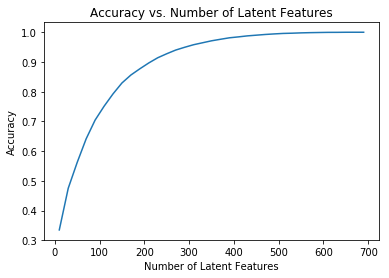

In [72]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [73]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [74]:
print('The size of the test set is {} and of the train set {} users.'.format(len(test_idx), user_item_train.shape[0]))

The size of the test set is 682 and of the train set 4487 users.


In [75]:
users_in_test_and_train = len(list(set(test_idx) & set(user_item_train.index)))
print('Do make predictions on the test set, the user has to be in the train set as well.\n{} users are in each set. For those users we can make predictions in the test set.'.format(users_in_test_and_train))

Do make predictions on the test set, the user has to be in the train set as well.
20 users are in each set. For those users we can make predictions in the test set.


In [76]:
print('The cold start problem apperas if a user if a user is not in the train set.\n{} Are only in the test set.'.format(len(test_idx)-len(list(set(test_idx) & set(user_item_train.index)))))

The cold start problem apperas if a user if a user is not in the train set.
662 Are only in the test set.


In [77]:
print('The size of the test set is {} and of the train set {} articles.'.format(len(test_arts), user_item_train.shape[1]))

The size of the test set is 574 and of the train set 714 articles.


In [78]:
users_in_test_and_train = len(list(set(test_arts) & set(user_item_train.columns)))
print('Do make predictions on the test set, the articles has to be in the train set as well.\n{} articles are in each set. For those users we can make predictions in the test set.'.format(users_in_test_and_train))

Do make predictions on the test set, the articles has to be in the train set as well.
574 articles are in each set. For those users we can make predictions in the test set.


In [79]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many movies can we make predictions for in the test set?': b, # letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [80]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = svd(user_item_train, full_matrices=True)# fit svd similar to above then use the cells below
u_train.shape, s_train.shape, vt_train.shape 

((4487, 4487), (714,), (714, 714))

In [81]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [82]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []


# decomposition to predict on test data
row_idx = user_item_train.index.isin(test_idx)
col_idx = user_item_train.columns.isin(test_arts)

u_test = u_train[row_idx, :]
vt_test = vt_train[:, col_idx]

# users of the test set what can predicted using SVD
users_can_predict = list(set(user_item_train.index) & set(user_item_test.index))
    
for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_est = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_est = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_est)
    diffs_test = np.subtract(user_item_test.loc[users_can_predict,:], user_item_test_est)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    sum_errs_train.append(err_train)
        
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(err_test)

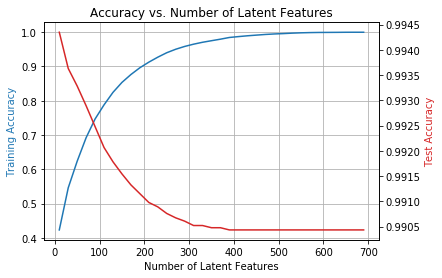

In [83]:
# plotting the training and test accuracies
fig, ax1 = plt.subplots()

ax1.set_xlabel('Number of Latent Features')
ax1.grid()
ax1.set_ylabel('Training Accuracy', color='tab:blue')
ax1.plot(num_latent_feats, 1 - np.array(sum_errs_train)/df.shape[0], color='tab:blue')
ax1.set_title('Accuracy vs. Number of Latent Features')

ax2 = ax1.twinx()  # instantiate a twin x axis

ax2.set_ylabel('Test Accuracy', color='tab:red')  # we already handled the x-label with ax1
ax2.plot(num_latent_feats, 1 - np.array(sum_errs_test)/df.shape[0], color='tab:red')

plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

## **Conclusion**
**On the one hand, the test data accuracy decreases with the number of latent features. On the other hand, the training accuracy increases by an increase of the number of latent features. This shows a pattern of overfitting. To avoid this,  the number of latent features should be kept low. As we have seen above, for the given set SVD is only apple to give recommendations 20 users. This are the users what are in the test as in the training set as well. Furthermore, the high test accuracy greater than 0.99 is an indicator for a unsatisfying matrix.**

**If we look at the intersection between the “Training Accuracy” and “Testing Accuracy” lines we can see that for both lines the absolute gradient declaims. If you take this point and go down to the x axis a appropriate number of latent features can be determined. In this case they number would be below 80 features. Anyway, SCD seams to be more appropriated than rank-based and collaborative filtering. For further improvements on the recommendation engine A/B testing could be used to approach the cold start problem because as we saw, matrix factorization is problematic in this case.**  

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [84]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0